## Nov 11th
- Try the YouTuBe-VOS dataset

### Dataset

In [1]:
import os
import json
import torch
import random
import cv2
import math
import numpy as np
import torchvision
from pathlib import Path
from torch import nn
from torch import optim
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.nn import functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt 
import matplotlib
import tqdm
from PIL import Image
from sklearn.metrics import jaccard_score

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tau = 3

In [50]:
def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
data_path = Path("C:/Users/Siyao/Downloads/YOUTUBE-VOS/train_zip/train/")
namefile = data_path / "meta.json"
with open(namefile) as file:
    train_file = json.load(file)

In [9]:
namefile

WindowsPath('C:/Users/Siyao/Downloads/YOUTUBE-VOS/train_zip/train/meta.json')

In [6]:
train_file['videos']

{'003234408d': {'objects': {'1': {'category': 'penguin',
    'frames': ['00000',
     '00005',
     '00010',
     '00015',
     '00020',
     '00025',
     '00030',
     '00035',
     '00040',
     '00045',
     '00050',
     '00055',
     '00060',
     '00065',
     '00070',
     '00075',
     '00080',
     '00085',
     '00090',
     '00095',
     '00100',
     '00105',
     '00110',
     '00115',
     '00120',
     '00125',
     '00130',
     '00135',
     '00140',
     '00145',
     '00150',
     '00155',
     '00160',
     '00165',
     '00170',
     '00175']},
   '2': {'category': 'penguin',
    'frames': ['00000',
     '00005',
     '00010',
     '00015',
     '00020',
     '00025',
     '00030',
     '00035',
     '00040',
     '00045',
     '00050',
     '00055',
     '00060',
     '00065',
     '00070',
     '00075',
     '00080',
     '00085',
     '00090',
     '00095',
     '00100',
     '00105',
     '00110',
     '00115',
     '00120',
     '00125',
     '00130',
     '0

In [8]:
for i in train_file['videos']:
    cls = []
    for j in train_file['videos'][i]['objects']:
        cls.append(j)
    print(cls)

['1', '2', '3', '4', '5']
['1', '2', '3']
['1']
['1', '2']
['1']
['1', '2', '3']
['1']
['1']
['1']
['1', '2', '3', '4', '5']
['1', '2']
['1', '2']
['1']
['1']
['1', '2']
['1']
['1']
['1', '2', '3']
['1', '2', '3', '4']
['1', '2']
['1', '2', '3']
['1', '2']
['1']
['1']
['1']
['1']
['1']
['1', '2']
['1']
['1', '2', '3']
['1', '2', '3']
['1', '2', '3']
['1', '2', '3', '4', '5']
['1', '2', '3']
['1', '2', '3', '4']
['1', '2']
['1', '2']
['1']
['1']
['1', '2', '3']
['1']
['1', '2', '3']
['1']
['1']
['1']
['1', '2', '3', '4']
['1']
['1', '2']
['1']
['1', '2', '3']
['1']
['1', '2']
['1', '2', '3']
['1', '2']
['1']
['1']
['1', '2']
['1']
['1']
['1']
['1', '2', '3']
['1']
['1', '2', '3']
['1']
['1', '2']
['1', '2']
['1']
['1']
['1', '2']
['1', '2', '3']
['1', '2']
['1', '2']
['1']
['1']
['1', '2']
['1', '2', '3']
['1']
['1', '2', '3']
['1']
['1', '2']
['1']
['1', '2', '3']
['1', '2']
['1', '2', '3']
['1', '2', '3', '4']
['1']
['1', '2']
['1', '2', '3', '4']
['1']
['1', '2']
['1', '2', '3']
['1'

In [6]:
json_path = 'C:/Users/Siyao/Downloads/YOUTUBE-VOS/train_zip/train/meta.json'
with open(json_path) as file:
    train_file = json.load(file)
type(train_file)

TypeError: the JSON object must be str, bytes or bytearray, not TextIOWrapper

In [189]:
class YouTubeVOS(Dataset):
	def __init__(self, dataset_folder=None, transforms_train=None, transform_test =None):
		self.dataset_folder = Path("C:/Users/Siyao/Downloads/YOUTUBE-VOS/train_zip/train")
		self.JPEGPath = str(os.path.join(self.dataset_folder,'JPEGImages'))
		self.AnnPath = str(os.path.join(self.dataset_folder,'Annotations'))
		self.json_path = str(os.path.join(self.dataset_folder,'meta.json'))
		self.transforms = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize([256,448]),
                                    # transforms.ColorJitter(0.4,0.4,0.4),
                                    # transforms.GaussianBlur(3,(0.1,5)),
                                    transforms.ToTensor()
                                ]) 
		self.transform_test = transform_test
		self.folders = os.listdir(self.JPEGPath)
		with open(self.json_path) as file:
   			self.json_file = json.load(file)

		
	def __getitem__(self,index):
		data_dict = {}
		folder_name = self.folders[index]
		object_list = (list(self.json_file['videos'][folder_name]['objects'].keys()))	# List of objects in current video
		frameid_list = self.json_file['videos'][folder_name]['objects'][object_list[0]]['frames']
		image_list = []
		mask_list = []
		for frame_num in frameid_list:
			image_path = self.JPEGPath + '/' + folder_name + '/' + frame_num + '.jpg'
			mask_path = self.AnnPath + '/' + folder_name + '/' + frame_num + '.png'
			image_array = load_image(image_path)
			# image_tensor = torch.from_numpy(image_array)
			image_tensor = self.transforms(image_array)
			image_list.append(image_tensor)
			mask_array = np.array(Image.open(mask_path).convert('P'), dtype=np.uint8)	# Convert mask from RGB to 1D
			mask_tensor = torch.from_numpy(mask_array)
			mask_list.append(mask_tensor)

		image_stack = torch.stack(image_list, dim=0)
		data_dict['Frames'] = image_stack
		data_dict['Masks'] = torch.stack(mask_list, dim=0)
		data_dict['Preds'] = torch.zeros(image_stack.shape)
		data_dict['Num_objs'] = len(object_list)
		return data_dict


	def __len__(self): 
		return len(self.folders)

In [190]:
ytb_ds = YouTubeVOS()
data = ytb_ds[0]
# data["frames"].shape, data["masks"].shape
type(data)

dict

In [194]:
data['Preds'].shape

torch.Size([36, 3, 256, 448])

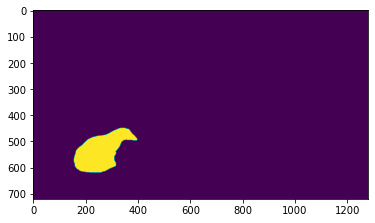

In [188]:
plt.imshow(data['Masks'][0]==1)

In [151]:
img = load_image("C:\\Users\\Siyao\\Downloads\\YOUTUBE-VOS\\train_zip\\train\\Annotations\\7a13a5dfaa\\00005.png")
img = torch.from_numpy(img)
img.shape
plt.imshow(img)

AttributeError: 'Tensor' object has no attribute 'shapeplt'

In [150]:
msk = Image.open("C:\\Users\\Siyao\\Downloads\\YOUTUBE-VOS\\train_zip\\train\\Annotations\\0b9d012be8\\00005.png").convert('P')
msk = np.array(msk)
np.unique(msk)

array([0, 1], dtype=uint8)

In [99]:
img[400,200]

tensor([236,  95, 103], dtype=torch.uint8)

In [158]:
dataset.json_file['videos']['7a13a5dfaa']['objects']

{'1': {'category': 'ape',
  'frames': ['00000',
   '00005',
   '00010',
   '00015',
   '00020',
   '00025',
   '00030',
   '00035',
   '00040',
   '00045',
   '00050',
   '00055',
   '00060',
   '00065',
   '00070',
   '00075',
   '00080',
   '00085',
   '00090',
   '00095',
   '00100',
   '00105',
   '00110',
   '00115',
   '00120',
   '00125',
   '00130',
   '00135',
   '00140',
   '00145',
   '00150',
   '00155',
   '00160',
   '00165',
   '00170',
   '00175']},
 '2': {'category': 'ape',
  'frames': ['00000',
   '00005',
   '00010',
   '00015',
   '00020',
   '00025',
   '00030',
   '00035',
   '00040',
   '00045',
   '00050',
   '00055',
   '00060',
   '00065',
   '00070',
   '00075',
   '00080',
   '00085',
   '00090',
   '00095',
   '00100',
   '00105',
   '00110',
   '00115',
   '00120',
   '00125',
   '00130',
   '00135',
   '00140',
   '00145',
   '00150',
   '00155',
   '00160',
   '00165',
   '00170',
   '00175']},
 '3': {'category': 'ape',
  'frames': ['00090',
   '00095',


In [157]:
dataset = dataLoader_5fps()
dic = dataset.json_file['videos']['7a13a5dfaa']
segPixel = (list(dataset.json_file['videos']['7a13a5dfaa']['objects'].keys()))
print(segPixel)

['1', '2', '3']


In [94]:
video_seq = dataset[0]
video_seq.shape

torch.Size([36, 720, 1280, 3])

In [82]:
video_seq = dataset[0]
video_seq.shape

torch.Size([36, 720, 1280, 3])

In [49]:
frame_list = dataset.json_file['videos']['2d01eef98e']['objects'][segPixel[0]]['frames']
frame_list

['00000',
 '00005',
 '00010',
 '00015',
 '00020',
 '00025',
 '00030',
 '00035',
 '00040',
 '00045',
 '00050',
 '00055',
 '00060',
 '00065',
 '00070',
 '00075',
 '00080',
 '00085',
 '00090',
 '00095',
 '00100',
 '00105',
 '00110',
 '00115',
 '00120',
 '00125',
 '00130',
 '00135',
 '00140',
 '00145',
 '00150',
 '00155',
 '00160',
 '00165',
 '00170',
 '00175']

In [156]:
image_path = dataset.JPEGPath + '/' + '7a13a5dfaa' + '/' + frame_list[1] + '.jpg'
image = load_image(image_path)
plt.imshow(image)

AttributeError: 'Youtube_MO_Train' object has no attribute 'JPEGPath'

In [100]:
import os
import os.path as osp
import numpy as np
from PIL import Image

import torch
import torchvision
from torch.utils import data
import random
import glob
# import pdb
import cv2
# from dataset.aug import aug_heavy
MAX_OBJECT_NUM_PER_SAMPLE = 5


In [137]:
class Youtube_MO_Train(data.Dataset):
    # for multi object, do shuffling

    def __init__(self, root):
        self.root = root
        self.mask_dir = os.path.join(root, 'Annotations')
        self.image_dir = os.path.join(root, 'JPEGImages')

        # self.videos = [i for i in glob.glob(os.path.join(self.image_dir,'*'))]
        self.videos = [i.split("\\")[-1] for i in glob.glob(os.path.join(self.image_dir,'*'))]
        self.num_frames = {}
        self.img_files = {}
        self.mask_files = {}
        for _video in self.videos:
            tmp_imgs = glob.glob(os.path.join(self.image_dir, _video,'*.jpg'))
            tmp_masks = glob.glob(os.path.join(self.mask_dir, _video,'*.png'))
            tmp_imgs.sort()
            tmp_masks.sort()
            self.img_files[_video] = tmp_imgs
            self.mask_files[_video] = tmp_masks
            self.num_frames[_video] = len(tmp_imgs)



        self.K = 11
        self.skip = 0

    def __len__(self):
        return len(self.videos)

    def change_skip(self,f):
        self.skip = f

    def To_onehot(self, mask):
        M = np.zeros((self.K, mask.shape[0], mask.shape[1]), dtype=np.uint8)
        for k in range(self.K):
            M[k] = (mask == k).astype(np.uint8)
        return M
    
    def All_to_onehot(self, masks):
        Ms = np.zeros((self.K, masks.shape[0], masks.shape[1], masks.shape[2]), dtype=np.uint8)
        for n in range(masks.shape[0]):
            Ms[:,n] = self.To_onehot(masks[n])
        return Ms

    def mask_process(self,mask,f,num_object,ob_list):
        n = num_object
        mask_ = np.zeros(mask.shape).astype(np.uint8)
        if f == 0:
            for i in range(1,11):
                if np.sum(mask == i) > 0:
                    n += 1
                    ob_list.append(i)
            if n > MAX_OBJECT_NUM_PER_SAMPLE:
                n = MAX_OBJECT_NUM_PER_SAMPLE
                ob_list = random.sample(ob_list,n)
        for i,l in enumerate(ob_list):
            mask_[mask == l] = i + 1
        return mask_,n,ob_list            


    def __getitem__(self, index):
        video = self.videos[index]
        img_files = self.img_files[video]
        mask_files = self.mask_files[video]
        info = {}
        info['name'] = video
        info['num_frames'] = self.num_frames[video]
        # info['size_480p'] = self.size_480p[video]

        N_frames = np.empty((3,)+(384,384,)+(3,), dtype=np.float32)
        N_masks = np.empty((3,)+(384,384,), dtype=np.uint8)
        frames_ = []
        masks_ = []
        n1 = random.sample(range(0,self.num_frames[video] - 2),1)[0]
        n2 = random.sample(range(n1 + 1,min(self.num_frames[video] - 1,n1 + 2 + self.skip)),1)[0]
        n3 = random.sample(range(n2 + 1,min(self.num_frames[video],n2 + 2 + self.skip)),1)[0]
        frame_list = [n1,n2,n3]
        num_object = 0
        ob_list = []
        for f in range(3):
            img_file = img_files[frame_list[f]]
            tmp_frame = np.array(Image.open(img_file).convert('RGB'))
            try:
                mask_file = mask_files[frame_list[f]]  
                tmp_mask = np.array(Image.open(mask_file).convert('P'), dtype=np.uint8)
            except:
                tmp_mask = 255

            h,w = tmp_mask.shape
            if h < w:
                tmp_frame = cv2.resize(tmp_frame, (int(w/h*480), 480), interpolation=cv2.INTER_LINEAR)
                tmp_mask = Image.fromarray(tmp_mask).resize((int(w/h*480), 480), resample=Image.NEAREST)  
            else:
                tmp_frame = cv2.resize(tmp_frame, (480, int(h/w*480)), interpolation=cv2.INTER_LINEAR)
                tmp_mask = Image.fromarray(tmp_mask).resize((480, int(h/w*480)), resample=Image.NEAREST) 

            frames_.append(tmp_frame)
            masks_.append(np.array(tmp_mask))

        for f in range(3):
            masks_[f],num_object,ob_list = self.mask_process(masks_[f],f,num_object,ob_list)
            N_frames[f],N_masks[f] = frames_[f],masks_[f]

        Fs = torch.from_numpy(np.transpose(N_frames.copy(), (3, 0, 1, 2)).copy()).float()
        Ms = torch.from_numpy(self.All_to_onehot(N_masks).copy()).float()

        if num_object == 0:
            num_object += 1
        num_objects = torch.LongTensor([num_object])
        return Fs, Ms, num_objects, info


In [141]:
dataset = Youtube_MO_Train('C:/Users/Siyao/Downloads/YOUTUBE-VOS/train_zip/train/')


ValueError: could not broadcast input array from shape (480,853,3) into shape (384,384,3)

In [118]:
dataset.image_dir

'C:/Users/Siyao/Downloads/YOUTUBE-VOS/train_zip/train/JPEGImages'

In [119]:
dataset.videos[0]

'JPEGImages\\003234408d'

In [117]:
tmp_imgs = glob.glob(os.path.join(dataset.image_dir, dataset.videos[0],'*.jpg'))
tmp_imgs

[]

In [113]:
dataset.num_frames

{'JPEGImages\\003234408d': 0,
 'JPEGImages\\0043f083b5': 0,
 'JPEGImages\\0044fa5fba': 0,
 'JPEGImages\\005a527edd': 0,
 'JPEGImages\\0065b171f9': 0,
 'JPEGImages\\00917dcfc4': 0,
 'JPEGImages\\00a23ccf53': 0,
 'JPEGImages\\00ad5016a4': 0,
 'JPEGImages\\01082ae388': 0,
 'JPEGImages\\011ac0a06f': 0,
 'JPEGImages\\013099c098': 0,
 'JPEGImages\\0155498c85': 0,
 'JPEGImages\\01694ad9c8': 0,
 'JPEGImages\\017ac35701': 0,
 'JPEGImages\\01b80e8e1a': 0,
 'JPEGImages\\01baa5a4e1': 0,
 'JPEGImages\\01c3111683': 0,
 'JPEGImages\\01c4cb5ffe': 0,
 'JPEGImages\\01c76f0a82': 0,
 'JPEGImages\\01c783268c': 0,
 'JPEGImages\\01e64dd36a': 0,
 'JPEGImages\\01ed275c6e': 0,
 'JPEGImages\\01ff60d1fa': 0,
 'JPEGImages\\020cd28cd2': 0,
 'JPEGImages\\02264db755': 0,
 'JPEGImages\\0248626d9a': 0,
 'JPEGImages\\02668dbffa': 0,
 'JPEGImages\\0274193026': 0,
 'JPEGImages\\02d28375aa': 0,
 'JPEGImages\\02f3a5c4df': 0,
 'JPEGImages\\031ccc99b1': 0,
 'JPEGImages\\0321b18c10': 0,
 'JPEGImages\\0348a45bca': 0,
 'JPEGImag

### Models